# CANARIE 2017 -- Analysis of the survey

This notebook is the first draft to analyse the results from [CANARIE]()

In [10]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import csv


In [7]:
# Load dataset
df = pd.read_csv('./dataset/2017 Cdn Research Software Developer Survey - Public data.csv')
# Number of row == number of participants
len(df.index)

,Response ID,Date submitted,Last page,Start language,Date started,Date last action,In which country do you work?,In which country do you work? [Other],Do you write software for research as part of your job?,What is the highest level of education you have attained?,...,How is your current research software work funded? [Canadian Institutes of Health Research (CIHR)],How is your current research software work funded? [Genome Canada],How is your current research software work funded? [Natural Sciences and Engineering Research Council of Canada (NSERC)],How is your current research software work funded? [Social Sciences and Humanities Research Council (SSHRC)],How is your current research software work funded? [I don't know],How is your current research software work funded? [Other],Have you developed software that is accessed from multiple institutions?,Do any of your current or previous projects make use of the Canadian Access Federation (CAF) Federated Identity Management (FIM) service?,"List any public identity providers (e.g. Google, Facebook, Live, LinkedIn, Twitter, etc.) used in your current or previous projects.",Unnamed: 95
0,40,2017-02-28 14:21:28,13,en,2017-02-28 14:13:24,2017-02-28 14:21:28,Canada,NaN,No,Doctorate,...,No,No,No,Yes,No,NaN,Yes,I'm not familiar with CAF,NaN,NaN
1,41,2017-02-28 17:01:45,13,fr,2017-02-28 14:13:56,2017-02-28 17:01:45,Canada,NaN,Yes,Doctorate,...,No,No,Yes,Yes,No,NaN,Yes,No,NaN,NaN
2,42,2017-02-28 14:29:05,13,en,2017-02-28 14:14:30,2017-02-28 14:29:05,Canada,NaN,Yes,Doctorate,...,No,No,Yes,No,No,NaN,No,I'm not familiar with CAF,NaN,NaN
3,43,2017-02-28 14:22:04,13,en,2017-02-28 14:14:57,2017-02-28 14:22:04,Canada,NaN,No,Some College,...,No,No,No,No,Yes,NaN,No,No,NaN,NaN
4,44,2017-02-28 14:26:41,13,fr,2017-02-28 14:16:35,2017-02-28 14:26:41,Canada,NaN,Yes,Masters Degree,...,Yes,Yes,Yes,No,No,NaN,Yes,I'm not familiar with CAF,NaN,NaN


## Country
A question asked the participants in which country they were currently working and specify when it was not Canada.


In [25]:
pd.crosstab(df['In which country do you work?'], columns='Countries')

col_0,Countries
In which country do you work?,
Canada,110
Other,4


There is only 4 others. Which are only one from Japan, 2 from USA and one from UK.  

In [28]:
pd.crosstab(df['In which country do you work? [Other]'], columns='Other countries')


col_0,Other countries
In which country do you work? [Other],
Japan,1
USA,2
uk,1


As this answer are not useful for CANARIE, because these people are not working in Canada, they are removed from the dataset.

In [43]:
df = df.loc[df['In which country do you work?'] != 'Other']
# Getting the number of row from the reduced dataframe
len(df.index)

110

## Languages

The survey was in French and in English. The option choose by the participant was collected. It is possible then to see the proportion of participants that answered the survey in French or in English

In [41]:
pd.crosstab(df['Start language'], columns='Language')


col_0,Language
Start language,
en,96
fr,14


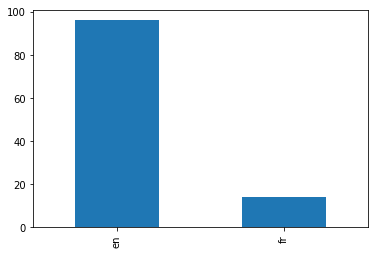

In [42]:
df['Start language'].value_counts().plot(kind='bar')


## Education level

The next question was about the education level. The different answers where:
